In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
from pudl import analysis
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import matplotlib as mpl
pudl_engine = pudl.db_connect_pudl()
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

# FERC Fuel and Steam Plant Table Data

In [2]:
steam_df = analysis.get_steam_ferc1_df()
fuel_df = analysis.get_fuel_ferc1_df()
steam_df = analysis.consolidate_ferc1_expns(steam_df, min_capfac=0.6, min_corr=0.5)
plants_by_primary_fuel = analysis.primary_fuel_ferc1(fuel_df, fuel_thresh=0.5)

steam_df = steam_df.merge(plants_by_primary_fuel)
steam_df['heat_rate_btu_per_kwh'] = (steam_df['total_mmbtu']*1e6) / (1000*steam_df['net_generation_mwh'])
steam_df['capacity_factor'] = steam_df['net_generation_mwh'] / (steam_df['total_capacity_mw']*8760)
coal_plants_ferc1 = steam_df[steam_df['primary_fuel']=='coal']
coal_plants_ferc1 = coal_plants_ferc1.drop('primary_fuel', axis=1)

# EIA923  Plants & Generation Fuel Tables

In [3]:
pt = models.PUDLBase.metadata.tables

gf_select = sa.sql.select([
    pt['generation_fuel_eia923'],
    pt['plants_eia923'].c.plant_name,
    pt['plants_eia923'].c.plant_id_pudl,
]).where(pt['generation_fuel_eia923'].c.plant_id == pt['plants_eia923'].c.plant_id)

gf_df = pd.read_sql(gf_select, pudl_engine)
gf_df['report_date'] = pd.to_datetime(gf_df['report_date'])
gf_df.index = gf_df['report_date']
# groupby plant_id and by year
gf_gb = gf_df.groupby([pd.TimeGrouper(freq='A'), 'plant_id','plant_name','plant_id_pudl'])
# sum net_gen by year by plant and convert to dataframe
plants_eia = gf_gb.agg({'fuel_consumed_total_mmbtu' : np.sum,
                        'net_generation_mwh' : np.sum})
plants_eia['heat_rate_btu_per_kwh'] = (plants_eia['fuel_consumed_total_mmbtu']*1000000) / (plants_eia['net_generation_mwh']*1000)
plants_eia = plants_eia.reset_index()
plants_eia['year'] = pd.DatetimeIndex(plants_eia['report_date']).year
plants_eia.drop('report_date', axis=1, inplace=True)

# EIA860 Plants Table

In [4]:
# Pull in the plant_eia860 table
plants_eia860_select = sa.sql.select([pt['plants_eia860'],]) # creates a sqlalchemy select object
plants_eia860 = pd.read_sql(plants_eia860_select, pudl_engine) # Uses the select to populate a DataFrame

eia860_cols = [
    'operator_id',
    'operator_name',
    'plant_id',
    'state',
    'grid_voltage_kv',
    'grid_voltage_2_kv',
    'grid_voltage_3_kv',
    'year'
]

plants_eia860 = plants_eia860[eia860_cols].copy()
plants_eia = plants_eia.merge(plants_eia860, on=['plant_id','year'])

# EIA923 Fuel Receipts & Costs Table

In [5]:
frc_tbl = models.PUDLBase.metadata.tables['fuel_receipts_costs_eia923']
frc_select = sa.sql.select([
    frc_tbl.c.plant_id,
    frc_tbl.c.report_date,
    frc_tbl.c.fuel_quantity,
    frc_tbl.c.fuel_group,
    frc_tbl.c.average_heat_content,
    frc_tbl.c.fuel_cost
])
frc_df = pd.read_sql(frc_select, pudl_engine)
frc_df = frc_df.dropna()
frc_df['fuel_cost'] = frc_df['fuel_cost'] / 100.0
frc_df['total_fuel_cost'] = frc_df.fuel_quantity * frc_df.average_heat_content * frc_df.fuel_cost

frc_df['report_date'] = pd.to_datetime(frc_df['report_date'])
frc_df.index = frc_df['report_date']
frc_gb = frc_df.groupby([pd.TimeGrouper(freq='A'), 'plant_id'])

frc_agg = frc_gb.agg({'total_fuel_cost' : np.sum})
frc_agg = frc_agg.reset_index()
frc_agg['year'] = pd.DatetimeIndex(frc_agg['report_date']).year
frc_agg.drop('report_date',axis=1,inplace=True)

plants_eia = plants_eia.merge(frc_agg, on=['year','plant_id'])

# EIA860 Generators Table

In [6]:
gen_eia860_tbl = models.PUDLBase.metadata.tables['generators_eia860']
gen_eia860_select = sa.sql.select([
    gen_eia860_tbl.c.year,
    gen_eia860_tbl.c.plant_id,
    gen_eia860_tbl.c.plant_name,
    gen_eia860_tbl.c.operator_id,
    gen_eia860_tbl.c.operator_name,
    gen_eia860_tbl.c.generator_id,
    gen_eia860_tbl.c.state,
    gen_eia860_tbl.c.nameplate_capacity_mw,
    gen_eia860_tbl.c.operating_year,
    gen_eia860_tbl.c.planned_retirement_year,
    gen_eia860_tbl.c.technology])

gen_eia860_df = pd.read_sql(gen_eia860_select, pudl_engine)

# Add capacity -- summed across generators by plant_id
gen_eia860_gb = gen_eia860_df.groupby(['plant_id','year'])
plant_capacity = gen_eia860_gb.agg({'nameplate_capacity_mw': np.sum})
plant_capacity = plant_capacity.reset_index()
plants_eia = plants_eia.merge(plant_capacity, on=['plant_id','year'])

# Add operator names:
operators = gen_eia860_df[['operator_id','operator_name','year']].drop_duplicates()
plants_eia.drop('operator_name', axis=1, inplace=True)
plants_eia = plants_eia.merge(operators, on=['operator_id','year'])

# Add technology, taking 2015 values:
coal_techs = ['Conventional Steam Coal', 'Coal Integrated Gasification Combined Cycle']
techs = gen_eia860_df[gen_eia860_df['year']==2015][['plant_id','technology']]
plants_eia = plants_eia.merge(techs, on='plant_id', how='outer').drop_duplicates()

# Filter to include only coal plants, from 2011-2015, capacity >=50MW

In [7]:
# First, let's limit our data to the years 2011-2015
years_to_get = [2011, 2012, 2013, 2014, 2015]
coal_plants_eia = plants_eia[plants_eia.year.isin(years_to_get)]
coal_plants_ferc1 = coal_plants_ferc1[coal_plants_ferc1.report_year.isin(years_to_get)]

# Now, let's grab only those plants larger than 50MW
coal_plants_eia = coal_plants_eia[coal_plants_eia['nameplate_capacity_mw']>=50]
coal_plants_ferc1 = coal_plants_ferc1[coal_plants_ferc1['total_capacity_mw']>=50]

# Now the hard part -- getting just "coal" plants. What does that mean?
# For FERC it's easy (and already done, above).
# For EIA, it's more complicated.  EIA 860 categorizes generators by technology
# in recent years (2014-2015) but not before that. Additionally, there are
# many plants which have received some portion of their fuel as coal, but which
# don't seem to show up in the EIA 860 list of coal plant IDs.  So we'll build up
# a list of plant_id values from the fuel_receipts_costs_eia923 table, the
# generation_fuel_eia923 table, and the plants_eia860 table.

# Plants with >10% coal fuel heat content in any of the years 2011-2015:
# from fuel_recipts_costs_eia923
frc_by_heat = analysis.plant_fuel_proportions_frc_eia923(frc_df)
frc_coal_plant_ids = frc_by_heat[frc_by_heat['Coal'] > 0.1].plant_id.unique()

# And from generation_fuel_eia923
gf_by_heat = analysis.plant_fuel_proportions_gf_eia923(gf_df)
gf_coal_plant_ids = gf_by_heat[gf_by_heat['coal'] > 0.1].plant_id.unique()

# Any plant that's specifically got a coal fired unit called out in EIA 860:
eia860_coal_plant_ids = gen_eia860_df[gen_eia860_df['technology'].isin(coal_techs)].plant_id.unique()

all_eia_coal_plant_ids = np.unique(np.concatenate([frc_coal_plant_ids,
                                                   gf_coal_plant_ids,
                                                   eia860_coal_plant_ids]))

coal_plants_eia = coal_plants_eia[coal_plants_eia['plant_id'].isin(all_eia_coal_plant_ids)]

coal_plants_eia = coal_plants_eia[(coal_plants_eia.technology.isnull()) | (coal_plants_eia.technology.isin(coal_techs))]
coal_plants_eia['capacity_factor'] = coal_plants_eia.net_generation_mwh / (coal_plants_eia.nameplate_capacity_mw * 8760)
coal_plants_eia.dropna(subset=['year'], inplace=True)
coal_plants_eia.year = coal_plants_eia.year.astype(int)
coal_plants_eia.operator_id = coal_plants_eia.operator_id.astype(int)
coal_plants_eia.plant_id_pudl = coal_plants_eia.plant_id_pudl.astype(int)

# Do some validation of the data we're going to deliver

### Caveats to communicate:
* We're just including coal plants categorized as such by EIA860 (2014-2015). There are other ways to categorize plants by fuel, but would involve more processing -- looking at fuel type consumed by different plants.
* Could also do a generator-level analysis if per-unit heat rates, capacity factors, etc were more useful.
* We only looked at coal plants currently in operation, but EIA860 also lists planned and retired plants, which could be integrated into the output if that was something that you wanted.

# Output data to an Excel spreadsheet for delivery
* Order fields with index-like fields first, reported quantities, and derived quantities later.
* Group fields thematically.
* Rename fields so that comparable fields from the two tables have the same name.
* Rename fields so that non-comparable fields from the two tables have different names.

In [8]:
# Re-order the columns for easier readability
coal_plants_eia = coal_plants_eia[[
    'year',
    'operator_id', # => utility_id_eia
    'operator_name', # => utility_name_eia
    'plant_id', # plant_id_eia
    'plant_id_pudl',
    'plant_name', # => plant_name_eia
    'state',
    
    'nameplate_capacity_mw',
    'net_generation_mwh',
    'capacity_factor',   
    'fuel_consumed_total_mmbtu',
    'heat_rate_btu_per_kwh',
    'total_fuel_cost', # => expns_fuel
    
    'grid_voltage_kv',
    'grid_voltage_2_kv',
    'grid_voltage_3_kv',
    'technology'
]]

eia_rename = {
    'operator_id': 'utility_id_eia',
    'plant_name': 'plant_name_eia',
    'plant_id': 'plant_id_eia',
    'operator_name': 'utility_name_eia',
    'total_fuel_cost': 'expns_fuel'
}

coal_plants_ferc1 = coal_plants_ferc1[[
    'report_year', # => year
    'respondent_id', # => utility_id_ferc
    'util_id_pudl', # => utility_id_pudl
    'respondent_name', # => utility_name_ferc
    'plant_id_pudl',
    'plant_name', # => plant_name_ferc
    'year_constructed',
    'year_installed',
    
    'total_capacity_mw', # nameplate_capacity_mw
    'water_limited_mw',
    'not_water_limited_mw',
    'peak_demand_mw',
    'plant_hours',
    
    'net_generation_mwh',
    'capacity_factor',
    'total_mmbtu', # => fuel_consumed_total_mmbtu
    'heat_rate_btu_per_kwh',
    
    'expns_operations',
    'expns_coolants',
    'expns_steam',
    'expns_steam_other',
    'expns_transfer',
    'expns_electric',
    'expns_misc_power',
    'expns_rents',
    'expns_allowances',
    'expns_engineering',
    'expns_structures',
    'expns_boiler',
    'expns_plants',
    'expns_misc_steam',
    
    'expns_fuel',
    'expns_total_nonfuel_production',
    'expns_total_nonproduction',
    'expns_production_total', # => expns_total
    'expns_per_mwh'
]]

ferc1_rename = {
    'report_year': 'year',
    'respondent_id': 'utility_id_ferc',
    'respondent_name': 'utility_name_ferc',
    'util_id_pudl': 'utility_id_pudl',
    'plant_name': 'plant_name_ferc',
    'total_capacity_mw': 'nameplate_capacity_mw',
    'total_mmbtu': 'fuel_consumed_total_mmbtu',
    'expns_production_total': 'expns_total'
}

eia860_rename = {
    'plant_id': 'plant_id_eia',
    'plant_name': 'plant_name_eia',
    'operator_id': 'utility_id_eia',
    'operator_name': 'utility_name_eia',
    'generator_id': 'generator_id_eia'
}

In [9]:
coal_plants_ferc1.rename(columns=ferc1_rename, inplace=True)
coal_plants_eia.rename(columns=eia_rename, inplace=True)
ferc_annotations = pd.read_csv('ferc1_field_annotations.csv')
eia_annotations = pd.read_csv('eia_field_annotations.csv')
gen_eia860_annotations = pd.read_csv('gen_eia860_field_annotations.csv')

xlsx_writer = pd.ExcelWriter('plant_info_for_ce.xlsx')
coal_plants_ferc1.to_excel(xlsx_writer, sheet_name='FERC Coal Plants', index=False)
ferc_annotations.to_excel(xlsx_writer, sheet_name='FERC Annotations', index=False)
coal_plants_eia.to_excel(xlsx_writer, sheet_name='EIA Coal Plants', index=False)
eia_annotations.to_excel(xlsx_writer, sheet_name='EIA Annotations', index=False)
gen_eia860_df.to_excel(xlsx_writer, sheet_name='EIA 860 Generators', index=False)
gen_eia860_annotations.to_excel(xlsx_writer, sheet_name='EIA 860 Generator Annotations', index=False)
xlsx_writer.save()

# A few visual comparisons of similar FERC & EIA data.

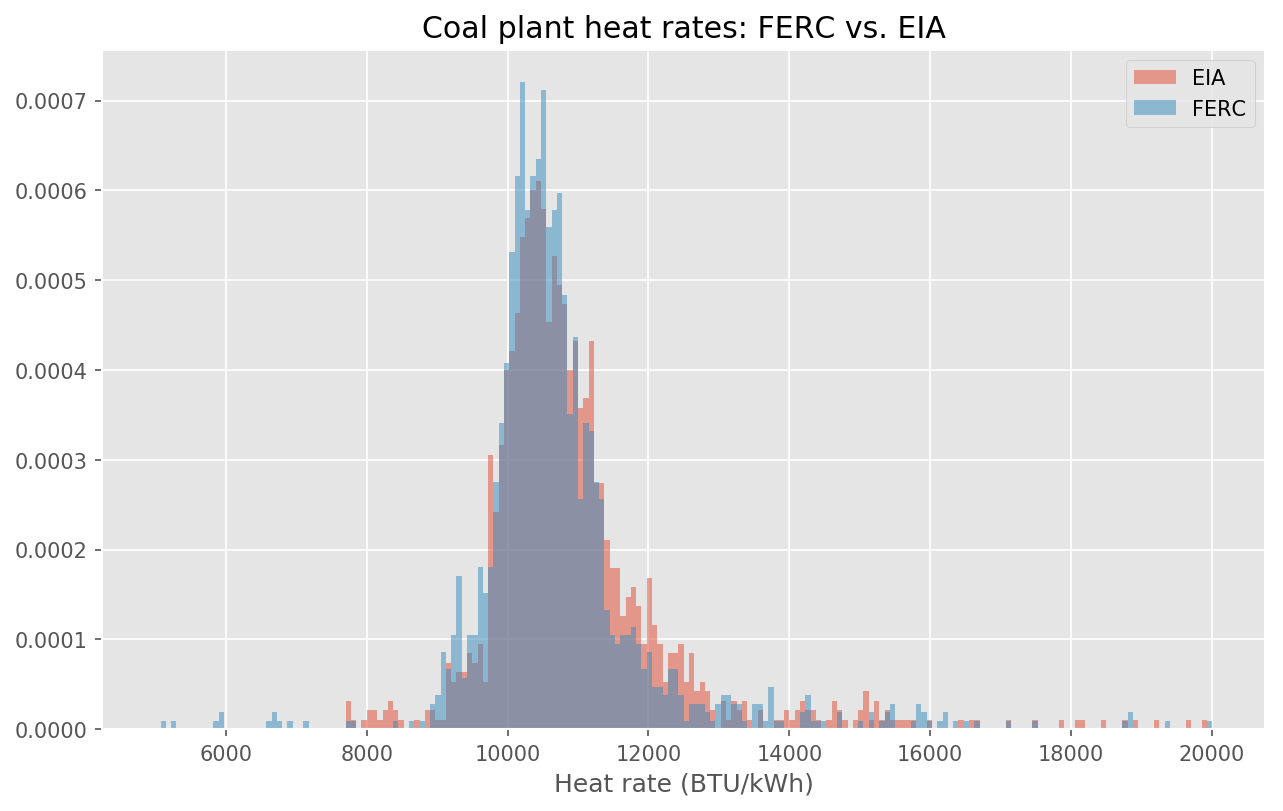

In [10]:
plt.hist(coal_plants_eia.heat_rate_btu_per_kwh, range=(5e3,2e4), bins=200, alpha=0.5, normed=True, label="EIA");
plt.hist(coal_plants_ferc1.heat_rate_btu_per_kwh, range=(5e3,2e4), bins=200, alpha=0.5, normed=True, label="FERC");
plt.xlabel("Heat rate (BTU/kWh)");
plt.title("Coal plant heat rates: FERC vs. EIA")
plt.legend();

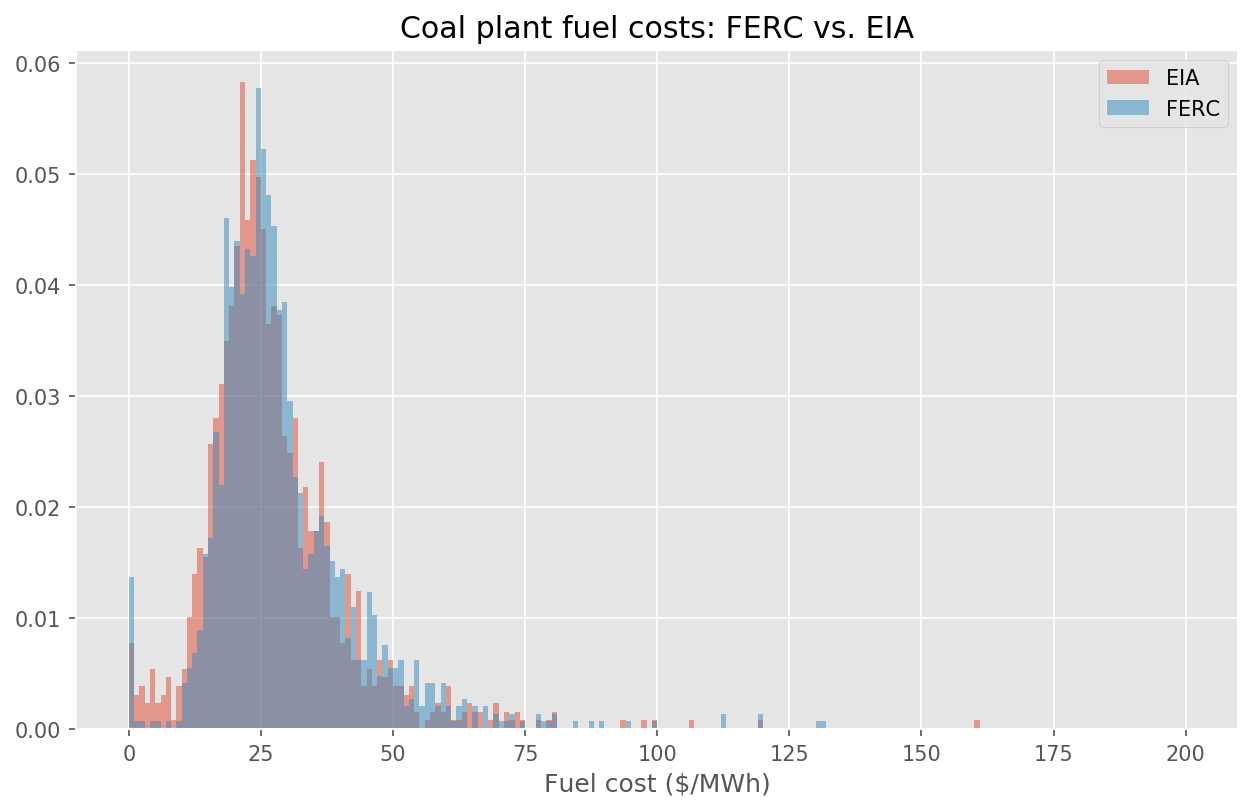

In [11]:
eia_fuel_cost_per_mwh = coal_plants_eia.expns_fuel / coal_plants_eia.net_generation_mwh
ferc_fuel_cost_per_mwh = coal_plants_ferc1.expns_fuel / coal_plants_ferc1.net_generation_mwh
plt.hist(eia_fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, normed=True, label="EIA")
plt.hist(ferc_fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, normed=True, label="FERC")
plt.xlabel("Fuel cost ($/MWh)")
plt.title("Coal plant fuel costs: FERC vs. EIA")
plt.legend();

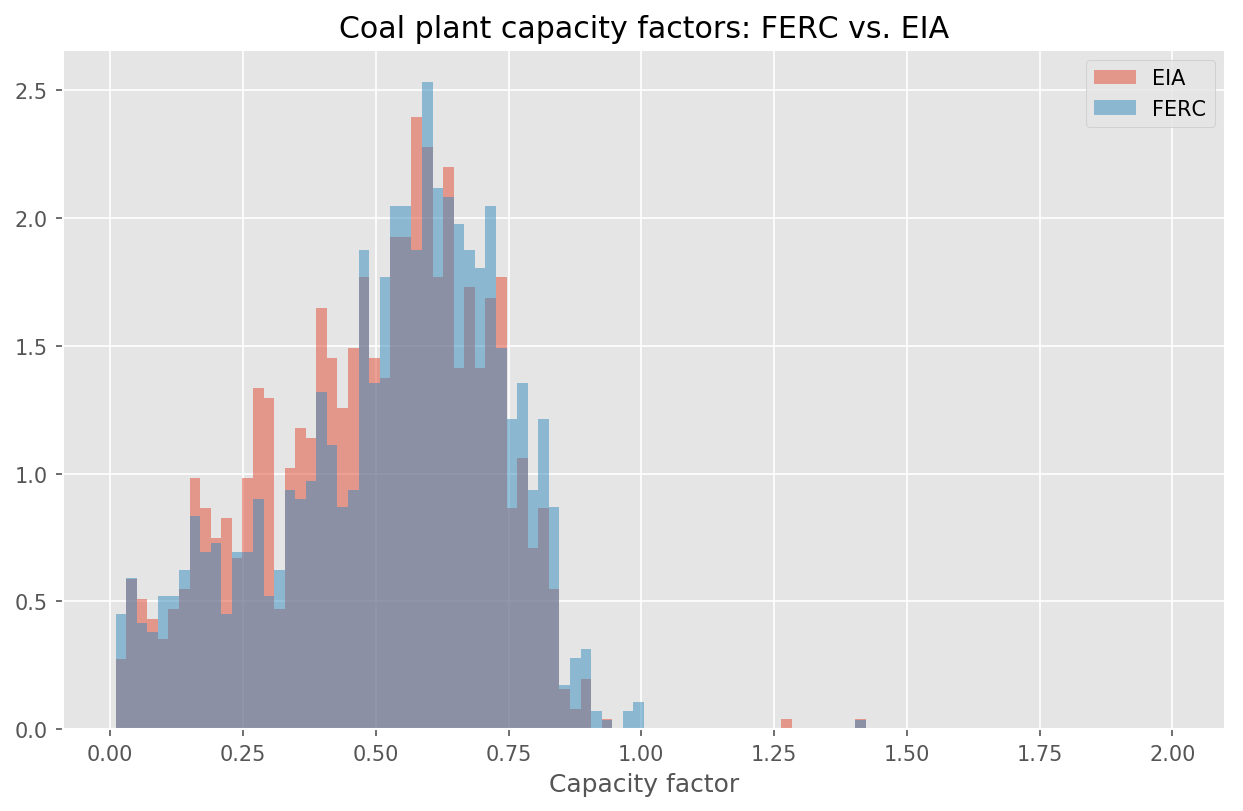

In [12]:
plt.hist(coal_plants_eia.capacity_factor, range=(0.01,2), bins=100, alpha=0.5, normed=True, label="EIA")
plt.hist(coal_plants_ferc1.capacity_factor, range=(0.01,2), bins=100, alpha=0.5, normed=True, label="FERC")
plt.xlabel("Capacity factor")
plt.title("Coal plant capacity factors: FERC vs. EIA")
plt.legend();

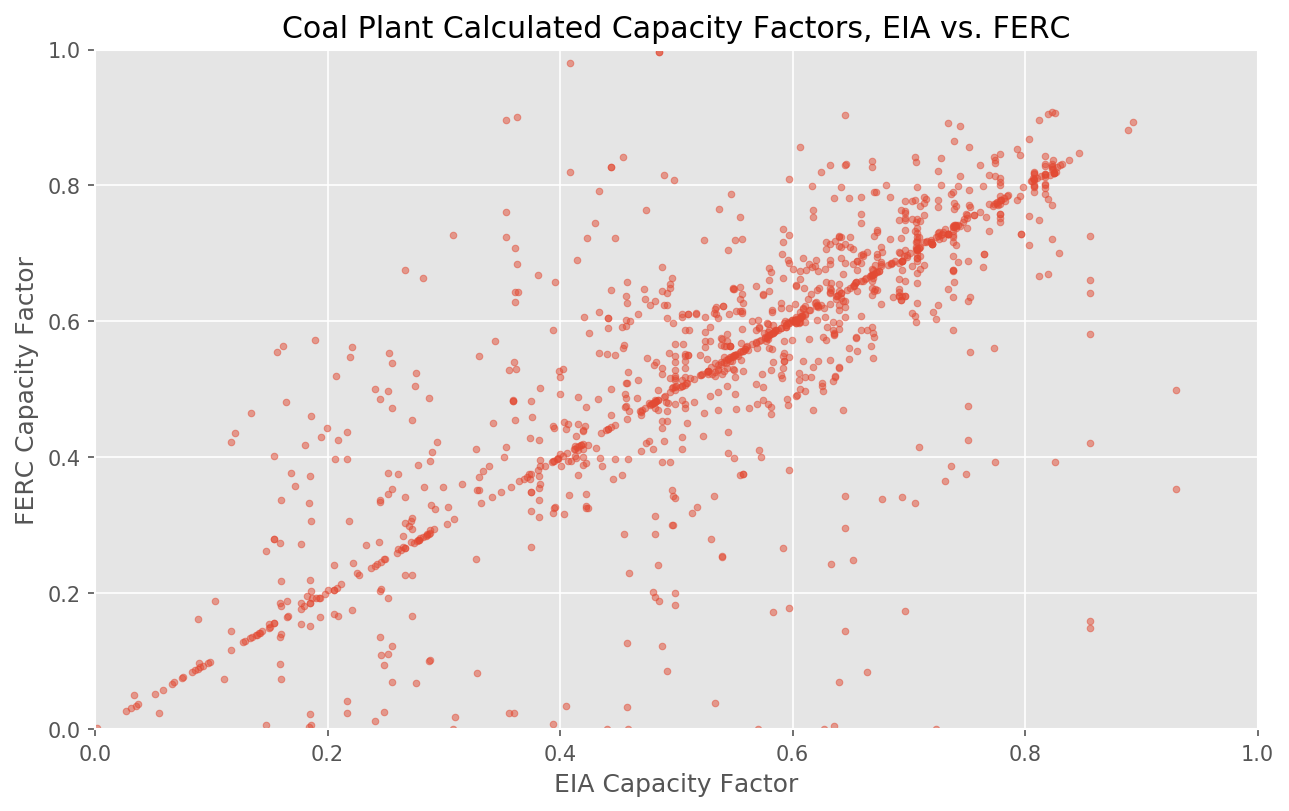

In [13]:
eia_capfac = coal_plants_eia[['year','plant_id_pudl','capacity_factor']]
eia_capfac = eia_capfac.rename(columns={'capacity_factor':'capfac_eia'})
ferc_capfac = coal_plants_ferc1[['year','plant_id_pudl','capacity_factor']]
ferc_capfac = ferc_capfac.rename(columns={'capacity_factor':'capfac_ferc'})
capfac = pd.merge(eia_capfac, ferc_capfac, on=['year','plant_id_pudl'])

plt.scatter(capfac.capfac_eia, capfac.capfac_ferc, s=10, alpha=0.5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("EIA Capacity Factor")
plt.ylabel("FERC Capacity Factor")
plt.title("Coal Plant Calculated Capacity Factors, EIA vs. FERC");

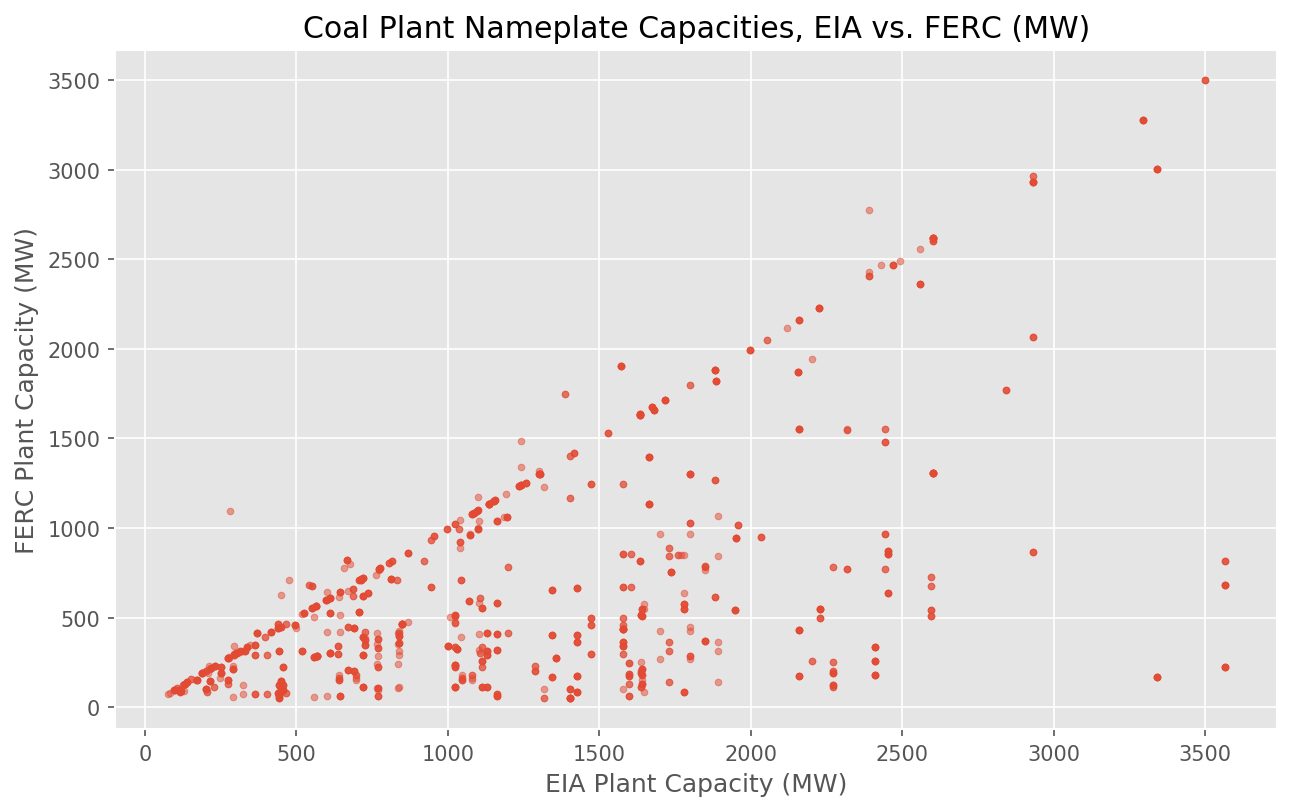

In [14]:
eia_cap = coal_plants_eia[['year','plant_id_pudl','nameplate_capacity_mw']]
eia_cap = eia_cap.rename(columns={'nameplate_capacity_mw':'capacity_eia'})
ferc_cap = coal_plants_ferc1[['year','plant_id_pudl','nameplate_capacity_mw']]
ferc_cap = ferc_cap.rename(columns={'nameplate_capacity_mw':'capacity_ferc'})
capacity = pd.merge(eia_cap, ferc_cap, on=['year','plant_id_pudl'])

plt.scatter(capacity.capacity_eia, capacity.capacity_ferc, s=10, alpha=0.5)
plt.xlabel('EIA Plant Capacity (MW)')
plt.ylabel('FERC Plant Capacity (MW)');
plt.title("Coal Plant Nameplate Capacities, EIA vs. FERC (MW)");